# Imports

In [1]:
import itertools
from collections import namedtuple

import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

from enum import IntEnum

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data import Dataset
import torchsummary

# Bulk data concatenation

In [39]:
data_path = "../../training_data/"
data_levelsets = ["train1", "train2", "train3", "train4"]
# data_levelsets = ["train5"]
data_levels = range(1, 990+1)
observation_ext = "observation.zip"
feature_ext = "feature.zip"

def addRowAndCol(feature_tensor):
    # 3xnxn -> 3x(n+1)x(n+1)
    n = feature_tensor.size()[1]
    channels = []
    new_col = torch.zeros(n, 1)
    new_row = torch.zeros(1, n+1)
    for channel in feature_tensor:
        output_tensor = torch.cat((channel, new_col), dim=1)
        output_tensor = torch.cat((output_tensor, new_row), dim=0)
        channels.append(output_tensor)
    return torch.stack(channels)
    

def dataGatherOnlyObservedSolutions():
    features = []
    observations = []
    for levelset, levelnum in itertools.product(*[data_levelsets, data_levels]):
        level_feature_path = '{}{}_{}_{}'.format(data_path, levelset, levelnum, feature_ext)
        level_observation_path = '{}{}_{}_{}'.format(data_path, levelset, levelnum, observation_ext)
        
        level_features = torch.load(level_feature_path)
        level_observations = torch.load(level_observation_path)
        
        for feat, obs in zip(level_features, level_observations):
            print(obs)
            if obs[1] == 1:
#                 features.append(feat.clone())
                features.append(addRowAndCol(feat.clone()))
                observations.append(torch.tensor([obs[0].clone()], dtype=torch.float32))
        del level_features
        del level_observations
                
    return torch.stack(features), torch.stack(observations)

# Data Preprocessing and Standardizing
- Features are standardized to mean 0 and std 1
- Observations are normalzed to range [0,1]

In [19]:
def preprocessFeatures(features):
    # features is shape [N, 2, 39, 39]
    # permute to channel is top most axis
    temp_feats = features.clone().permute(*[i for i in range(1, len(features.shape))], 0).contiguous()
    # Calculate mean/std for standardization
    mean = temp_feats.view(2, -1).mean(dim=1)
    std = temp_feats.view(2, -1).std(dim=1)
    # Normalize original features
    print(mean)
    print(std)
    for f in features:
        for i, (mu, sigma) in enumerate(zip(mean.tolist(), std.tolist())):
            f[i].sub_(mu)
            f[i].div_(sigma)
    
    return features

def preprocessObservations(observations):
    return torch.log(observations)
#     return observations / max(observations)
#     return torch.log(observations) / max(torch.log(observations))

def getDataLoader(features, observations, batch_size=64):
    data = [(feat, obs) for feat, obs in zip(features, observations)]
    return torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
        

# Model

In [4]:
class DisNetCNN(nn.Module):
    def __init__(self):
        super().__init__()
        ks1 = 3
        ks2 = 3
        ks3 = 1
        
        conv1_depth = 16
        conv2_depth = 32
        
        # convolution layers
        self.conv1 = nn.Conv2d(2, conv1_depth, kernel_size=ks1, stride=1, padding=1)
        torch.nn.init.xavier_uniform_(self.conv1.weight)
        self.conv2 = nn.Conv2d(conv1_depth, conv2_depth, kernel_size=ks2, stride=1, padding=1)
        torch.nn.init.xavier_uniform_(self.conv2.weight)
        self.conv3 = nn.Conv2d(conv2_depth, 1, kernel_size=ks3, stride=1, padding=0)
        torch.nn.init.xavier_uniform_(self.conv3.weight)
        
        # pooling
        self.maxPool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout2d(0.2)
#         self.avgPool = nn.AveragePool2d(2, 2)
        # subsampling
        
        # FC
        self.fc1 = nn.Linear(40*40, 64)
        torch.nn.init.xavier_uniform_(self.fc1.weight)
        self.fc2 = nn.Linear(64, 32)
        torch.nn.init.xavier_uniform_(self.fc2.weight)
        self.fc3 = nn.Linear(32, 1)
        torch.nn.init.xavier_uniform_(self.fc3.weight)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
    
    


In [5]:
class DisNetCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.dropout = nn.Dropout2d(0.2)
        self.fc1 = nn.Linear(40*40*2, 64)
        torch.nn.init.xavier_uniform_(self.fc1.weight)
        self.fc2 = nn.Linear(64, 32)
        torch.nn.init.xavier_uniform_(self.fc2.weight)
        self.fc3 = nn.Linear(32, 1)
        torch.nn.init.xavier_uniform_(self.fc3.weight)
    
    def forward(self, x):
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [ ]:
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform(m.weight.data)
# model.apply(weight_init)
# torch.manual_seed(your_seed)

# Train/Testing

In [8]:
Options = namedtuple('Options', ['n_epochs', 'batch_size', 'start_rate', 'end_rate', 'clip_gradient_norm', 'model', 'verbose'])
default_options = Options(n_epochs=100, batch_size=64, start_rate=1e-3, end_rate=1e-5, clip_gradient_norm=1e-2, 
                          model=DisNetCNN(), verbose=False)

In [9]:
def train(train_features, train_observations, test_features, test_observations, options=default_options):
    # Create dataloaders
    train_loader = getDataLoader(train_features, train_observations, options.batch_size)
    test_loader  = getDataLoader(test_features, test_observations, options.batch_size)
    
    # device
    device = torch.device("cuda:0")
    print(device)
    
    # Create model
    model = options.model
    model.to(device)
    
    # Loss function
    loss_fn = nn.MSELoss()
#     loss_fn = nn.NLLLoss()
    
    # Optimizers
    # - learning rate start 1e-3 to end 1e-5 [done]
    # - gradient clipping [done]
    # - tanh activation function
    # - SGD [done]
    # - batch normalization (as a layer)
    # - L2 regularization of 1e-4
    decay_rate = np.exp(np.log(options.end_rate / options.start_rate) / options.n_epochs)
    
    optimizer = optim.SGD(model.parameters(), lr=options.start_rate)
#     optimizer = optim.SGD(model.parameters(), lr=options.start_rate, weight_decay=0.01)
    lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=decay_rate)
    
    loss_values = []
    for epoch in range(options.n_epochs):
        training_loss = 0.0
        for i, data in enumerate(train_loader):
            # get the inputs; data is a list of [features, runtime]
            inputs, rts = data
            inputs, rts = inputs.to(device), rts.to(device)
            
            # zero the parameter gradients
            optimizer.zero_grad()
            
            # Propogate input to model and calculate loss
            batch_size = inputs.shape[0]
            outputs = model(inputs)
            loss = loss_fn(outputs, rts)
            
            # Add l2 loss
            
            # Clip the gradients
            if options.clip_gradient_norm != None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), options.clip_gradient_norm)
            
            # Propogate loss backwards and step optimizer
            loss.backward()
            optimizer.step()
            training_loss += loss.item()
            
        # Test 
        validation_loss = 0.0
        with torch.no_grad():
            for i, data in enumerate(test_loader):
                # get the inputs; data is a list of [features, runtime]
                inputs, rts = data
                inputs, rts = inputs.to(device), rts.to(device)

                outputs = model(inputs)
                loss = loss_fn(outputs, rts)
                validation_loss += loss
                    
            
        # Avg loss
#         loss_values.append(running_loss / len(train_loader))
        loss_values.append((epoch, training_loss / len(train_loader), 'train'))
        loss_values.append((epoch, validation_loss / len(test_loader), 'test'))
        if options.verbose and epoch % 10 == 9: print("Epoch: %d, Loss: %f" % (epoch, float(loss_values[-1])))
        
        # Update learning rate
        lr_scheduler.step()
    return loss_values, model

In [ ]:
def validate(features, observations, model, options=default_options):
    # Preprocess input
    features = preprocessFeatures(features)
    observations = preprocessObservations(observations)
    
    # Create dataloader
    test_loader = getDataLoader(features, observations, options.batch_size)
    
    with torch.no_grad():
        running_loss = 0.0
        for i, data in enumerate(train_loader):
            # get the inputs; data is a list of [features, runtime]
            inputs, rts = data
            inputs, rts = inputs.to(device), rts.to(device)

# K-Fold Testing

In [11]:
def kfold(features, observations, options=default_options):
    kf = KFold(features.shape[0], n_folds=5)
    loss_data = []
    
    for step, (train_index, test_index) in enumerate(kf):
        print('Fold: {}',format(step))
        # Split data
        train_features, test_features = features[train_index], features[test_index]
        train_observations, test_observations = observations[train_index], observations[test_index]
        
        # Preprocess Training input
        train_features = preprocessFeatures(train_features)
        train_observations = preprocessObservations(train_observations)

        # Preprocess Testing input
        test_features = preprocessFeatures(test_features)
        test_observations = preprocessObservations(test_observations)
        
        run_loss, _ = train(train_features, train_observations, test_features, test_observations, options)
        loss_data.append(run_loss)
        
    return loss_data
        

# Util

In [4]:
# Smooth plotting
def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

# Training loop

In [6]:
Options = namedtuple('Options', ['n_epochs', 'batch_size', 'start_rate', 'end_rate', 'clip_gradient_norm', 'verbose'])
default_options = Options(n_epochs=100, batch_size=64, start_rate=1e-3, end_rate=1e-5, clip_gradient_norm=1e-2, verbose=False)

In [7]:
# Get data
feats = torch.load('train_nokey_only_solution_feats.pt')
obs = torch.load('train_nokey_only_solution_obs.pt')

# Create training options
options = Options(n_epochs=200, batch_size=32, start_rate=1e-3, end_rate=1e-5, clip_gradient_norm=1e-2, verbose=False)
                  
# Dataframe
columns = ['Epoch', 'Loss', 'Run Type']
df = pd.DataFrame(columns=columns)
loss_data = kfold(feats, obs, options)
for row in loss_data:
    df = df.append(pd.Series(row, index=df.columns), ignore_index=True)

In [ ]:
# plot

# Validation Testing

In [ ]:
def validate(features, observations, model, options=default_options):
    # Preprocess input
    features = preprocessFeatures(features)
    observations = preprocessObservations(observations)
    
    # Create dataloader
    test_loader = getDataLoader(features, observations, options.batch_size)
    
    # Pg 191

In [223]:
feats = torch.load('train_nokey_only_solution_feats.pt')
obs = torch.load('train_nokey_only_solution_obs.pt')
o = Options(n_epochs=200, batch_size=32, start_rate=1e-3, end_rate=1e-5, clip_gradient_norm=1e-2, verbose=True)
loss_values, model = train(feats, obs, o)

cuda:0
Epoch: 9, Loss: 4.783046
Epoch: 19, Loss: 4.715307
Epoch: 29, Loss: 4.187537
Epoch: 39, Loss: 3.975315
Epoch: 49, Loss: 3.766761
Epoch: 59, Loss: 4.258517
Epoch: 69, Loss: 4.006995
Epoch: 79, Loss: 3.740915
Epoch: 89, Loss: 3.438899
Epoch: 99, Loss: 3.899374
Epoch: 109, Loss: 3.650785
Epoch: 119, Loss: 3.679715
Epoch: 129, Loss: 3.392409
Epoch: 139, Loss: 3.991889
Epoch: 149, Loss: 3.756386
Epoch: 159, Loss: 3.445402
Epoch: 169, Loss: 4.049201
Epoch: 179, Loss: 3.598160
Epoch: 189, Loss: 4.001225
Epoch: 199, Loss: 3.717004


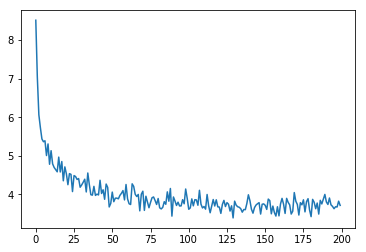

In [226]:
plt.plot(smooth(loss_values, 1))

In [207]:
device = torch.device("cuda:0")
index = 1208
f = preprocessFeatures(feats)[index:index+1].to(device)
o = preprocessObservations(obs)[index:index+1]
print(model(f))
print(o)

tensor([[2.9833]], device='cuda:0', grad_fn=<FeatureDropoutBackward>)
tensor([[3.3673]])


In [172]:
summary(model, (2, 40, 40))

RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

In [11]:

# feats, obs = dataGatherOnlyObservedSolutions()
# torch.save(feats, 'train_nokey_only_solution_feats.pt')
# torch.save(obs, 'train_nokey_only_solution_obs.pt')

In [158]:
feats = torch.load('train_nokey_only_solution_feats.pt')
obs = torch.load('train_nokey_only_solution_obs.pt')
print(feats.shape)
print(obs.shape)

torch.Size([3960, 2, 40, 40])
torch.Size([3960, 1])


In [77]:
permTempFeats

tensor([[[[0.2014, 0.8822, 0.1140, 0.8369],
          [0.2918, 0.7020, 0.7541, 0.3556],
          [0.5786, 0.8386, 0.7378, 0.5152],
          [0.9454, 0.2910, 0.9145, 0.5884]],

         [[0.7923, 0.7909, 0.1098, 0.3195],
          [0.4803, 0.4007, 0.6035, 0.5743],
          [0.0171, 0.2761, 0.9388, 0.6652],
          [0.5459, 0.6032, 0.4494, 0.3658]]],


        [[[0.7770, 0.7051, 0.3316, 0.8457],
          [0.2978, 0.7117, 0.1090, 0.3297],
          [0.6302, 0.1306, 0.3089, 0.6453],
          [0.1877, 0.4400, 0.6960, 0.0021]],

         [[0.6115, 0.4842, 0.6426, 0.3837],
          [0.9901, 0.3421, 0.5447, 0.2467],
          [0.8325, 0.7696, 0.2741, 0.2561],
          [0.2276, 0.2711, 0.4679, 0.4610]]],


        [[[0.3534, 0.6828, 0.2816, 0.1926],
          [0.4594, 0.9886, 0.3416, 0.1624],
          [0.8285, 0.4373, 0.4972, 0.4604],
          [0.5750, 0.9687, 0.7848, 0.4529]],

         [[0.0018, 0.5595, 0.9077, 0.3239],
          [0.2525, 0.5788, 0.6479, 0.9415],
          [0.1342,

In [78]:
temp1 = preprocessFeatures(permTempFeats)
print(temp1)

torch.Size([2, 4, 4, 3])
torch.Size([2, 48])
tensor([0.5242, 0.5069])
tensor([0.2678, 0.2553])
tensor([[[[-1.2056,  1.3370, -1.5320,  1.1678],
          [-0.8682,  0.6639,  0.8585, -0.6299],
          [ 0.2030,  1.1740,  0.7977, -0.0338],
          [ 1.5730, -0.8710,  1.4576,  0.2395]],

         [[ 1.1182,  1.1127, -1.5556, -0.7341],
          [-0.1041, -0.4160,  0.3785,  0.2643],
          [-1.9189, -0.9039,  1.6920,  0.6203],
          [ 0.1530,  0.3772, -0.2251, -0.5525]]],


        [[[ 0.9440,  0.6756, -0.7194,  1.2005],
          [-0.8456,  0.7002, -1.5508, -0.7266],
          [ 0.3958, -1.4700, -0.8040,  0.4520],
          [-1.2569, -0.3144,  0.6414, -1.9500]],

         [[ 0.4101, -0.0887,  0.5317, -0.4824],
          [ 1.8931, -0.6453,  0.1483, -1.0191],
          [ 1.2756,  1.0292, -0.9119, -0.9826],
          [-1.0943, -0.9238, -0.1526, -0.1799]]],


        [[[-0.6380,  0.5920, -0.9061, -1.2384],
          [-0.2422,  1.7343, -0.6820, -1.3513],
          [ 1.1363, -0.3245, 

In [52]:
temp1 = [0.2014, 0.8822, 0.1140, 0.8369, 0.2918, 0.7020, 0.7541, 0.3556, 0.5786, 0.8386, 0.7378, 0.5152, 0.9454, 0.2910, 0.9145, 0.5884, \
0.7770, 0.7051, 0.3316, 0.8457, 0.2978, 0.7117, 0.1090, 0.3297, 0.6302, 0.1306, 0.3089, 0.6453, 0.1877, 0.4400, 0.6960, 0.0021, \
0.3534, 0.6828, 0.2816, 0.1926, 0.4594, 0.9886, 0.3416, 0.1624, 0.8285, 0.4373, 0.4972, 0.4604, 0.5750, 0.9687, 0.7848, 0.4529]
sum(temp1) / len(temp1)

0.52423125

In [64]:
transform = transforms.Normalize()

TypeError: __init__() missing 2 required positional arguments: 'mean' and 'std'

In [2]:
class LossFunctionTypes(IntEnum):
    MSE = 0
    EXPONENTIAL = 1
    INVERSE_GAUSSIAN = 2
    LOG_NORMAL = 3

In [40]:
feats, obs = dataGatherOnlyObservedSolutions()

tensor([19.,  1.,  0.,  0.])
tensor([0., 0., 0., 0.])
tensor([0., 0., 0., 0.])
tensor([75.,  0.,  0.,  0.])
tensor([0., 0., 0., 0.])
tensor([0., 0., 0., 0.])
tensor([0., 0., 0., 0.])
tensor([0., 0., 0., 0.])
tensor([0., 0., 0., 0.])
tensor([0., 0., 0., 0.])
tensor([0., 0., 0., 0.])
tensor([0., 0., 0., 0.])
tensor([0., 0., 0., 0.])
tensor([0., 0., 0., 0.])
tensor([0., 0., 0., 0.])
tensor([0., 0., 0., 0.])
tensor([0., 0., 0., 0.])
tensor([0., 0., 0., 0.])
tensor([0., 0., 0., 0.])
tensor([0., 0., 0., 0.])
tensor([0., 0., 0., 0.])
tensor([0., 0., 0., 0.])
tensor([0., 0., 0., 0.])
tensor([0., 0., 0., 0.])
tensor([0., 0., 0., 0.])
tensor([0., 0., 0., 0.])
tensor([0., 0., 0., 0.])
tensor([0., 0., 0., 0.])
tensor([0., 0., 0., 0.])
tensor([0., 0., 0., 0.])
tensor([0., 0., 0., 0.])
tensor([0., 0., 0., 0.])
tensor([0., 0., 0., 0.])
tensor([0., 0., 0., 0.])
tensor([0., 0., 0., 0.])
tensor([0., 0., 0., 0.])
tensor([0., 0., 0., 0.])
tensor([0., 0., 0., 0.])
tensor([0., 0., 0., 0.])
tensor([0., 0., 0

tensor([1., 0., 1., 1.])
tensor([1., 0., 1., 1.])
tensor([1., 0., 1., 1.])
tensor([1., 0., 1., 1.])
tensor([1., 0., 1., 1.])
tensor([1., 0., 1., 1.])
tensor([1., 0., 1., 1.])
tensor([1., 0., 1., 1.])
tensor([1., 0., 1., 1.])
tensor([1., 0., 1., 1.])
tensor([1., 0., 1., 1.])
tensor([1., 0., 1., 1.])
tensor([1., 0., 1., 1.])
tensor([1., 0., 1., 1.])
tensor([1., 0., 1., 1.])
tensor([1., 0., 1., 1.])
tensor([1., 0., 1., 1.])
tensor([1., 0., 1., 1.])
tensor([1., 0., 1., 1.])
tensor([1., 0., 1., 1.])
tensor([1., 0., 1., 1.])
tensor([1., 0., 1., 1.])
tensor([1., 0., 1., 1.])
tensor([1., 0., 1., 1.])
tensor([1., 0., 1., 1.])
tensor([1., 0., 1., 1.])
tensor([1., 0., 1., 1.])
tensor([1., 0., 1., 1.])
tensor([1., 0., 1., 1.])
tensor([1., 0., 1., 1.])
tensor([1., 0., 1., 1.])
tensor([1., 0., 1., 1.])
tensor([1., 0., 1., 1.])
tensor([1., 0., 1., 1.])
tensor([1., 0., 1., 1.])
tensor([1., 0., 1., 1.])
tensor([1., 0., 1., 1.])
tensor([1., 0., 1., 1.])
tensor([1., 0., 1., 1.])
tensor([1., 0., 1., 1.])


tensor([0., 0., 0., 0.])
tensor([0., 0., 0., 0.])
tensor([0., 0., 0., 0.])
tensor([0., 0., 0., 0.])
tensor([0., 0., 0., 0.])
tensor([0., 0., 0., 0.])
tensor([0., 0., 0., 0.])
tensor([0., 0., 0., 0.])
tensor([0., 0., 0., 0.])
tensor([0., 0., 0., 0.])
tensor([0., 0., 0., 0.])
tensor([0., 0., 0., 0.])
tensor([0., 0., 0., 0.])
tensor([0., 0., 0., 0.])
tensor([0., 0., 0., 0.])
tensor([0., 0., 0., 0.])
tensor([0., 0., 0., 0.])
tensor([0., 0., 0., 0.])
tensor([0., 0., 0., 0.])
tensor([0., 0., 0., 0.])
tensor([0., 0., 0., 0.])
tensor([0., 0., 0., 0.])
tensor([0., 0., 0., 0.])
tensor([0., 0., 0., 0.])
tensor([0., 0., 0., 0.])
tensor([0., 0., 0., 0.])
tensor([0., 0., 0., 0.])
tensor([0., 0., 0., 0.])
tensor([0., 0., 0., 0.])
tensor([0., 0., 0., 0.])
tensor([0., 0., 0., 0.])
tensor([0., 0., 0., 0.])
tensor([0., 0., 0., 0.])
tensor([0., 0., 0., 0.])
tensor([0., 0., 0., 0.])
tensor([0., 0., 0., 0.])
tensor([1., 0., 1., 1.])
tensor([1., 0., 1., 1.])
tensor([1., 0., 1., 1.])
tensor([1., 0., 1., 1.])


tensor([1., 0., 1., 1.])
tensor([1., 0., 1., 1.])
tensor([1., 0., 1., 1.])
tensor([1., 0., 1., 1.])
tensor([1., 0., 1., 1.])
tensor([1., 0., 1., 1.])
tensor([1., 0., 1., 1.])
tensor([1., 0., 1., 1.])
tensor([1., 0., 1., 1.])
tensor([1., 0., 1., 1.])
tensor([1., 0., 1., 1.])
tensor([1., 0., 1., 1.])
tensor([1., 0., 1., 1.])
tensor([1., 0., 1., 1.])
tensor([1., 0., 1., 1.])
tensor([1., 0., 1., 1.])
tensor([1., 0., 1., 1.])
tensor([1., 0., 1., 1.])
tensor([1., 0., 1., 1.])
tensor([1., 0., 1., 1.])
tensor([1., 0., 1., 1.])
tensor([1., 0., 1., 1.])
tensor([1., 0., 1., 1.])
tensor([1., 0., 1., 1.])
tensor([1., 0., 1., 1.])
tensor([1., 0., 1., 1.])
tensor([1., 0., 1., 1.])
tensor([1., 0., 1., 1.])
tensor([1., 0., 1., 1.])
tensor([1., 0., 1., 1.])
tensor([1., 0., 1., 1.])
tensor([2., 1., 0., 0.])
tensor([0., 0., 0., 0.])
tensor([0., 0., 0., 0.])
tensor([0., 0., 0., 0.])
tensor([0., 0., 0., 0.])
tensor([0., 0., 0., 0.])
tensor([0., 0., 0., 0.])
tensor([0., 0., 0., 0.])
tensor([0., 0., 0., 0.])


KeyboardInterrupt: 

In [26]:
a = preprocessFeatures(feats)
# feats.clone().permute(1, 2, 3, 0).contiguous()[0]

tensor([0.1933, 0.0447])
tensor([0.1590, 0.1653])


In [28]:
feats.clone().permute(1, 2, 3, 0).contiguous()[0]

tensor([[[-1.2154, -1.2154, -1.2154,  ..., -1.2154, -1.2154, -1.2154],
         [-1.2154, -1.2154, -1.2154,  ..., -1.2154, -1.2154, -1.2154],
         [-1.2154, -1.2154, -1.2154,  ..., -1.2154, -1.2154, -1.2154],
         ...,
         [-1.2154, -1.2154, -1.2154,  ..., -1.2154, -1.2154, -1.2154],
         [-1.2154, -1.2154, -1.2154,  ..., -1.2154, -1.2154, -1.2154],
         [-1.2154, -1.2154, -1.2154,  ..., -1.2154, -1.2154, -1.2154]],

        [[-1.2154, -1.2154, -1.2154,  ..., -1.2154, -1.2154, -1.2154],
         [-1.2154, -1.2154, -1.2154,  ..., -1.2154, -1.2154, -1.2154],
         [-1.2154, -1.2154, -1.2154,  ..., -1.2154, -1.2154, -1.2154],
         ...,
         [-1.2154, -1.2154, -1.2154,  ..., -1.2154, -1.2154, -1.2154],
         [-1.2154, -1.2154, -1.2154,  ..., -1.2154, -1.2154, -1.2154],
         [-1.2154, -1.2154, -1.2154,  ..., -1.2154, -1.2154, -1.2154]],

        [[-1.2154, -1.2154, -1.2154,  ..., -1.2154, -1.2154, -1.2154],
         [-1.2154, -1.2154, -1.2154,  ..., -1

In [36]:
feats[0][0][0][0].add_(1)

tensor(-0.2154)

In [41]:
feats[0][0][0]

tensor([-0.2154, -1.2154, -1.2154,  3.2978,  3.2978, -1.2154, -1.2154, -1.2154,
        -1.2154, -1.2154, -1.2154, -1.2154, -1.2154, -1.2154, -1.2154, -1.2154,
        -1.2154, -1.2154, -1.2154, -1.2154, -1.2154, -1.2154, -1.2154, -1.2154,
        -1.2154,  3.2978, -1.2154, -1.2154, -1.2154, -1.2154,  3.2978,  3.2978,
         3.2978, -1.2154, -1.2154, -1.2154, -1.2154, -1.2154, -1.2154, -1.2154])

In [71]:
TWO_PI = 2 * np.pi
EPSILON = 1e-5
def _pdf_invgauss(x, mu, lambda_):
    helper = -(lambda_ * (x - mu)**2) / (2 * x * (mu**2))
    return (torch.sqrt(lambda_) / torch.sqrt(TWO_PI * (x**3))) * torch.exp(helper)

In [72]:
x = torch.Tensor([[0, 1], [1, 2], [2, 3]])
print(x)
mu = torch.Tensor([[1.0], [1.5], [2.0]])
lambda_ = torch.Tensor([[0.5], [1.0], [2.0]])
print(mu)
print(lambda_)
_pdf_invgauss(x + EPSILON, mu, lambda_)

tensor([[0., 1.],
        [1., 2.],
        [2., 3.]])
tensor([[1.0000],
        [1.5000],
        [2.0000]])
tensor([[0.5000],
        [1.0000],
        [2.0000]])


tensor([[0.0000, 0.2821],
        [0.3774, 0.1372],
        [0.1995, 0.0999]])

In [83]:
a = torch.Tensor([[0, 1], [1, 2], [2, 3]])
b = torch.Tensor([[10], [12], [3]])
print(a)
print(b)
print(a*b)

tensor([[0., 1.],
        [1., 2.],
        [2., 3.]])
tensor([[10.],
        [12.],
        [ 3.]])
tensor([[ 0., 10.],
        [12., 24.],
        [ 6.,  9.]])


In [79]:
x = torch.Tensor([[i/100 for i in range(0, 100+1)], [i/100 for i in range(0, 100+1)]])
y = torch.Tensor([[(i/100)**2 for i in range(0, 100+1)], [(i/100)**3 for i in range(0, 100+1)]])
torch.trapz(y, x)

tensor([0.3334, 0.2500])

In [125]:
STEPS = 10
targets = b[:,0]
print('targets')
print(targets)
# xs = torch.stack([torch.arange(0, i.item() + i.item()/float(STEPS), i.item()/float(STEPS)) for i in targets])
xs = torch.stack([torch.arange(0, STEPS+1) / float(STEPS) * i.item() for i in targets])
print(xs)
print('mu')
print(mu)
print('lambda')
print(lambda_)
pdfs = _pdf_invgauss(xs + EPSILON, mu, lambda_)
# print(pdfs)
print(torch.trapz(pdfs, xs))

targets
tensor([10., 12.,  3.])
tensor([[ 0.0000,  1.0000,  2.0000,  3.0000,  4.0000,  5.0000,  6.0000,  7.0000,
          8.0000,  9.0000, 10.0000],
        [ 0.0000,  1.2000,  2.4000,  3.6000,  4.8000,  6.0000,  7.2000,  8.4000,
          9.6000, 10.8000, 12.0000],
        [ 0.0000,  0.3000,  0.6000,  0.9000,  1.2000,  1.5000,  1.8000,  2.1000,
          2.4000,  2.7000,  3.0000]])
mu
tensor([[1.0000],
        [1.5000],
        [2.0000]])
lambda
tensor([[0.5000],
        [1.0000],
        [2.0000]])
tensor([0.4565, 0.5951, 0.8178])


In [103]:
for i in b[:,0]:
    print(i.item())

10.0
12.0
3.0


In [127]:
kf = KFold(n_splits=5, shuffle=True, random_state=0)
dataset_indices = list(range(10))
for train_idx, test_idx in kf.split(dataset_indices):
    print(train_idx)
    print(test_idx)
    print('')

[0 1 3 4 5 6 7 9]
[2 8]

[0 1 2 3 5 6 7 8]
[4 9]

[0 2 3 4 5 7 8 9]
[1 6]

[0 1 2 4 5 6 8 9]
[3 7]

[1 2 3 4 6 7 8 9]
[0 5]



In [7]:
a = torch.tensor([1,2,3])
print(a)
a = a.unsqueeze(-1)
print(a)

tensor([1, 2, 3])
tensor([[1],
        [2],
        [3]])
